In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
from tqdm import tqdm
from scipy import ndimage

In [2]:
import torch.nn.functional as F
import torch as tc
from helpers_img import *
from NeuralNets import *
from training_NN import *

# Valerio inizia da qui

In [3]:
# Loaded a set of images
root_dir = "training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
N = min(100, len(files)) # Load maximum 100 images
print("Loading " + str(N) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(N)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(N) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(N)]
print(files[0])

#n = 85 # Only use 85 images for training

Loading 100 images
satImage_052.png
Loading 100 images
satImage_052.png


In [4]:
# augment the dataset adding rotated images
imgs, gt_imgs = rotation(imgs, gt_imgs)
print('Total number of imgages: '+str(len(imgs)))

Total number of imgages: 400


In [5]:
def bootstrap_images(imgs, gt_imgs,size,number):
    '''This function returns a list of list. Each element of the "external" list is a list of randomly 
    sampled images with replacement'''
    
    new_imgs=[]
    new_gt_imgs=[]
    array = np.arange(len(imgs))
    matrix= np.zeros((len(imgs),number))
    for k in range(number):
        b = np.random.choice(array, size, replace=True)
        list_temp_imgs = [imgs[i] for i in b]
        list_temp_gt_imgs = [gt_imgs[i] for i in b]
        new_imgs.append(list_temp_imgs)
        new_gt_imgs.append(list_temp_gt_imgs)
        matrix[b,k]=1
    
    return new_imgs,new_gt_imgs,matrix

In [ ]:
? np.ndarray

In [6]:
def train_SimpleNet(dataset, label, w, h, lr, max_epochs, mini_batch_size, dropout):
    ''' Train a simple net'''
    n = len(dataset)
    train_sub_images = [img_crop(dataset[i], w, h) for i in range(n)]
    train_mask_label = [img_crop(label[i],w,h) for i in range(n)]
    train_mask_label = from_mask_to_vector(train_mask_label,0.3)
    train_sub_images = transform_subIMG_to_Tensor(train_sub_images)
    mean = train_sub_images.mean()
    std = train_sub_images.std()
    train_sub_images = (train_sub_images-mean)/std
    train_sub_images, train_mask_label = reduce_dataset(train_sub_images,train_mask_label)
    # shuffle images
    for l in range(10):
        new_indices= np.random.permutation(len(train_mask_label))
        train_sub_images=train_sub_images[new_indices]
        train_mask_label=train_mask_label[new_indices]
    
    model = SimpleNet(dropout)
    

    train_model_Adam( model, train_sub_images, train_mask_label, max_epochs, lr, mini_batch_size)
    
    return model



In [15]:
def bagging_NN(dataset, label, percentage_train_data, nb_model, w, h, lr, max_epochs, mini_batch_size, dropout):
    nb_data = int( len(dataset)*percentage_train_data )
    list_dataset, list_label, data_matrix = bootstrap_images(dataset, label, nb_data, nb_model)
    models = []
    for i in range(nb_model):
        model=train_SimpleNet(list_dataset[i], list_label[i], w, h, lr, max_epochs, mini_batch_size, dropout)
        models.append(model)
        print('model '+str(i)+' trained')
        
    data_matrix = 1 - data_matrix
    # the data matrix has 1 in position n,j if the nth image was not used in jth
    # model training.
    
    # compute F1 error
    
    test_imgs=[img_crop(dataset[k], w, h) for k in range(len(dataset))]
    nb_patches=len(test_imgs[0])
    test_imgs = transform_subIMG_to_Tensor(test_imgs)
    F1_error=0
    not_testable_img=0
    for i in range(len(dataset)):
        image= test_imgs.narrow(0,i*nb_patches,nb_patches)
        if data_matrix[i,:].sum()>0:
            ind=np.where(data_matrix[i,:])[0]
            predictions=[models[k](image).detach().numpy() for k in ind]
            predictions = np.array(predictions)
            predictions = predictions.mean(0)[:] >0.5
            mask_test = label_to_img(400, 400, w, h, predictions)
            F1_error += calcul_F1(label[i], mask_test)
        else:
            not_testable_img+=1
    
    F1_error= F1_error/(len(dataset)-not_testable_img)
    return models, F1_error
    

100%|██████████| 2/2 [01:03<00:00, 31.90s/it]


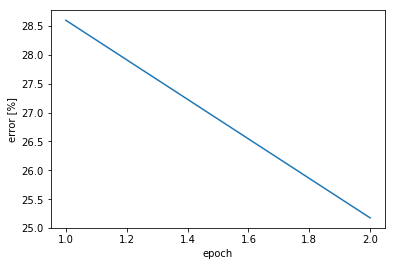

model 0 trained


100%|██████████| 2/2 [01:03<00:00, 31.90s/it]


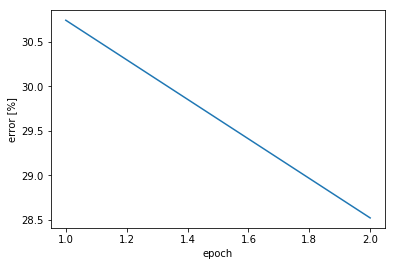

model 1 trained


In [ ]:
# valerio modifica questo
percentage_train_data=0.05
nb_model=2
w=16
h=16
lr=1e-4
max_epochs=2
mini_batch_size=1
dropout=0
models, F1_error= bagging_NN(imgs, gt_imgs, percentage_train_data, nb_model, w, h, lr, max_epochs, mini_batch_size, dropout)

In [12]:
a=np.array([[0,0],[0,1]])
ind= np.where(a[1,:])
print(ind)

(array([1]),)


# Valerio fermati qui

In [ ]:
n=90*3
N=len(imgs)
train_imgs=imgs[0:n]
train_mask=gt_imgs[0:n]
test_imgs=imgs[n:N]
test_mask = gt_imgs[n:N]


In [ ]:
temp=concatenate_images(train_imgs[3], train_mask[3])
plt.figure(figsize=(10, 10))
plt.imshow(temp)

In [ ]:
? tc.nn.Dropout

In [ ]:
print(len(train_mask))

In [ ]:
print(len(test_imgs),N-n)

In [ ]:
# prepare input data 
w=16
h=16
train_sub_images=[img_crop(train_imgs[i], w, h) for i in range(n)]
train_mask_label=[img_crop(train_mask[i],w,h) for i in range(n)]
train_mask_label=from_mask_to_vector(train_mask_label,0.3)
test_sub_images=[img_crop(test_imgs[i], w, h) for i in range(N-n)]
#test_mask_label=[img_crop(train_mask[n+i],w,h) for i in range(n)]
#test_mask_label=from_mask_to_vector(test_mask_label)


In [ ]:
print((1*train_mask_label).sum()/len(train_mask_label))

In [ ]:
print(len(train_sub_images[0]))

In [ ]:
train_sub_images = transform_subIMG_to_Tensor(train_sub_images)
test_sub_images = transform_subIMG_to_Tensor(test_sub_images)

In [ ]:
# normalize data
mean = train_sub_images.mean()
std = train_sub_images.std()
train_sub_images = (train_sub_images-mean)/std
train_sub_images, train_mask_label = reduce_dataset(train_sub_images,train_mask_label)
#print(train_sub_images[-1]-train_sub_images[-2])
for l in range(n):
    new_indices= np.random.permutation(len(train_mask_label))
    train_sub_images=train_sub_images[new_indices]
    train_mask_label=train_mask_label[new_indices]
#print(train_sub_images[0]-train_sub_images[1])
#train_sub_images.requires_grad_(True)

In [ ]:
 ? tc.Tensor.narrow

In [ ]:
print(train_mask_label.sum()/len(train_mask_label))

In [ ]:
model = SimpleNet(0)
lr=1e-4
max_epochs=15
mini_batch_size=1

train_model_Adam( model, train_sub_images, train_mask_label, max_epochs, lr, mini_batch_size)

In [ ]:
print(tc.__version__)

In [ ]:
? tc.mean

In [ ]:
N1=625

In [ ]:
# print the result on a single image
#N1=int(train_sub_images.size(0)/n)
image_test= test_sub_images.narrow(0,43*N1,N1)
image_test=(image_test-mean)/std
mask_array=model(image_test)
#print(mask_array.max())
mask_list=mask_array[:]>0.5
mask_test = label_to_img(400, 400, 16, 16, mask_list)

In [ ]:
# compute F1 score
mask=gt_imgs[n]
#print(mask.sum())
print(calcul_F1(mask, mask_test))

In [ ]:
# overlap images

print_img = make_img_overlay(imgs[n+43], mask_test)
#print_img = make_img_overlay(imgs[n+43], gt_imgs[n+43])
plt.figure(figsize=(10, 10))
plt.imshow(print_img)

In [ ]:
def compute_test_error(test_dataset, test_label, nb_patches, model):
    ''' compute the F1 error made during road segmentation. 
    Exemple: for a 16*16 patch we have that nb_patches=625'''
    model.is_train=False
    mean=test_dataset.mean()
    std= test_dataset.std()
    test_dataset = (test_dataset-mean)/std
    test_output = model(test_dataset)
    w = int(400/np.sqrt(nb_patches))
    F1_error=np.zeros(int(test_dataset.size(0)/nb_patches))
    for i in range(int(test_dataset.size(0)/nb_patches)):
        mask = test_output.narrow(0,i*nb_patches, nb_patches)
        mask = mask.detach().numpy()[:]>0.5
        mask = label_to_img(400, 400, w, w, mask)
        F1_error[i] = calcul_F1(test_label[i], mask)
    plt.figure()
    plt.plot(np.arange(int(test_dataset.size(0)/nb_patches))+1,F1_error)
    plt.xlabel('image')
    plt.ylabel('F1_error')
    F1_mean= np.mean(F1_error)
    return F1_mean
    

In [ ]:
F1=compute_test_error(test_sub_images, test_mask, 625, model)

In [ ]:
print(F1)